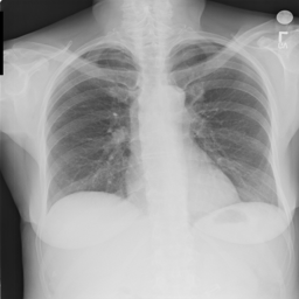

In [11]:
import numpy as np
import tensorflow as tf
import keras

import os
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline
from funcs_Task2_3 import concat_generators
preprocess_input = keras.applications.xception.preprocess_input
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

img_size = (128, 128)

# The local path to our target image
#img_path = "covid xray/test/COVID/COVID-2032.png"
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"
display(Image(img_path))

In [146]:
loaded_model = tf.keras.models.load_model('covid_xray_model.h5')  # Load the model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,725,507 (14.21 MB)

 Trainable params: 3,725,377 (14.21 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

### Redefine model so I have different output layer -> shape (1,2)

- We have to change the last layer to not have a scalar as output
- I here redefined the model completely because in task 2 I made it with sequential() and then it doesn't work for some reason

In [147]:
from tensorflow.keras import datasets, layers, models
METRICS = ["accuracy"]
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'
epochs = 30

#full_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')
training_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = training_data_gen.samples + val_data_gen.samples  #
total_val = val_data_gen.samples

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [148]:
learning_rate = 0.001
dropout_rate = 0.3
filters = 32

inputs = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', name="last_conv")(x)  # <-- Name this layer for Grad-CAM
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)  

redefined_model = Model(inputs, outputs)

redefined_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

redefined_model.summary()

history = redefined_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "functional_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,666 (7.07 MB)

 Trainable params: 1,853,602 (7.07 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.5707 - loss: 0.9253

c:\Users\lotte\anaconda3\envs\aiproject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 811ms/step - accuracy: 0.5748 - loss: 0.9149 - val_accuracy: 0.5677 - val_loss: 0.6666
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - accuracy: 0.7342 - loss: 0.5454 - val_accuracy: 0.5859 - val_loss: 0.6546
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 754ms/step - accuracy: 0.7407 - loss: 0.5275 - val_accuracy: 0.6146 - val_loss: 0.6455
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - accuracy: 0.7763 - loss: 0.4705 - val_accuracy: 0.6068 - val_loss: 0.6431
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 748ms/step - accuracy: 0.7645 - loss: 0.4772 - val_accuracy: 0.6068 - val_loss: 0.6367
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 738ms/step - accuracy: 0.7950 - loss: 0.4505 - val_accuracy: 0.6562 - val_loss: 0.6256
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 723ms/step - accuracy: 0.8004 - loss: 0.4416 - val_accuracy: 0.6432 - val_loss: 0.6217
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 735ms/step - accuracy: 0.7939 - loss: 0.4392 - val_accuracy: 0.653

### Functions to get image array and to make Grad-CAM map (from tutorial)

In [4]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)

    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, sublayer = None, pred_index=None):
    
    if sublayer is None:
        output = model.get_layer(last_conv_layer_name).output
    else:
        output = model.get_layer(last_conv_layer_name).get_layer(sublayer).output

    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        
        model.inputs, [output, model.output]
    )

    # We compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(tf.cast(img_array, tf.float32))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # For binary classification, just get the scalar output ????
        class_channel = preds[0][pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Average the gradients along the spatial dimension to get a proxy for the channel importance
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    #averaging the activations along the channel dimension, weighting each channel according to its importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

### grad-CAM for redefined baseline model

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

redefined_model.layers[-1].activation = None

# Print what the top predicted class is
preds = redefined_model.predict(img_array)
print(preds.shape)
print(preds, tf.nn.softmax(preds))
heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=0)

# Display heatmap
plt.matshow(heatmap)
plt.show()


NameError: name 'img_path' is not defined

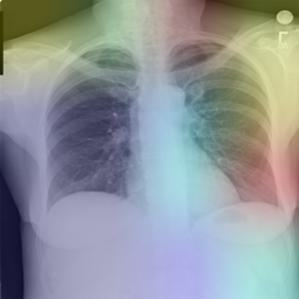

In [22]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.3, threshold=0.5, cmap="jet"):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps[cmap]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


display_gradcam(img_path, heatmap)


COVID:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: COVID-2032.png | Predictions (softmax output): [[0.97644675 0.02355328]]


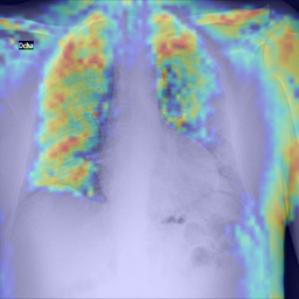

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: COVID-2063.png | Predictions (softmax output): [[0.98437655 0.01562343]]


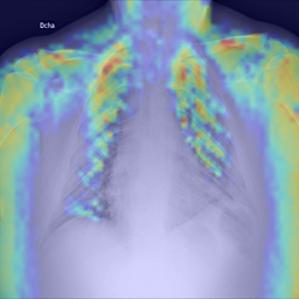

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: COVID-2048.png | Predictions (softmax output): [[0.9191039  0.08089606]]


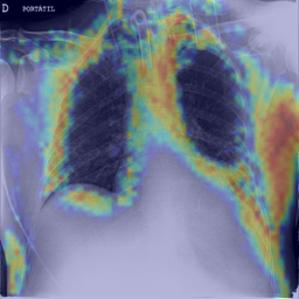


NORMAL:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: Normal-2004.png | Predictions (softmax output): [[0.82779247 0.17220755]]


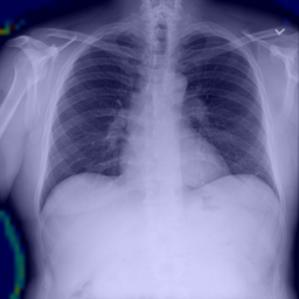

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: Normal-2097.png | Predictions (softmax output): [[0.886595   0.11340504]]


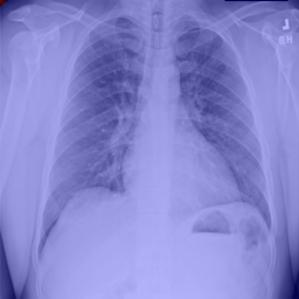

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: Normal-2046.png | Predictions (softmax output): [[0.9568075  0.04319245]]


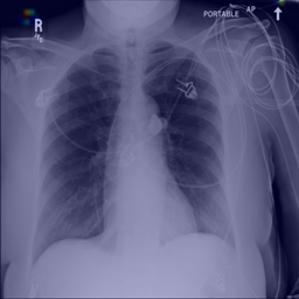

In [152]:
covid_folder = "covid xray/test/COVID"
normal_folder = "covid xray/test/NORMAL"

import random
# Pick random 3 images from each
covid_images = random.sample(os.listdir(covid_folder), 3)
normal_images = random.sample(os.listdir(normal_folder), 3)


# ----------- LOOP FOR COVID -----------
print("\nCOVID:\n")
for img_name in covid_images:
    img_path = os.path.join(covid_folder, img_name)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    redefined_model.layers[-1].activation = None
    preds = redefined_model.predict(img_array)
    print(f"Image: {img_name} | Predictions (softmax output): {tf.nn.softmax(preds)}")
    heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=0)
    display_gradcam(img_path, heatmap)

# ----------- LOOP FOR NORMAL -----------
print("\nNORMAL:\n")
for img_name in normal_images:
    img_path = os.path.join(normal_folder, img_name)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    redefined_model.layers[-1].activation = None
    preds = redefined_model.predict(img_array)
    print(f"Image: {img_name} | Predictions (softmax output): {tf.nn.softmax(preds)}")
    heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=1)
    display_gradcam(img_path, heatmap)

with pred_index = 0 you see the activation contributing to making the decision of covid
with pred_index = 1 you see the activation contributing to making the decision of normal

Looks like they are always classified as COVI


### Now lets try for Resnet model of task 3

In [14]:
def make_gradcam_heatmap(img_array, model, base_model_name, target_layer_name, pred_index=None):
    resnet_model = model.get_layer(base_model_name)
    target_layer = resnet_model.get_layer(target_layer_name)

    feature_extractor = keras.models.Model(
        inputs=resnet_model.input,
        outputs=target_layer.output
    )

    # Manually rebuild classifier after ResNet
    classifier_input = keras.Input(shape=target_layer.output.shape[1:])

    x = model.get_layer("global_average_pooling2d_27")(classifier_input)
    x = model.get_layer("dense_54")(x)
    x = model.get_layer("dropout_27")(x)
    x = model.get_layer("dense_55")(x)

    classifier = keras.models.Model(inputs=classifier_input, outputs=x)

    # Forward and backward passes
    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(img_array)
        tape.watch(conv_outputs)
        preds = classifier(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [[-1.8182768]]


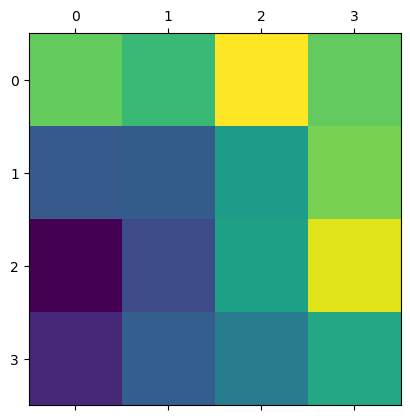

In [15]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = tf.convert_to_tensor(img_array)

# Make model
model = load_model("ResNet_finetuned_model.keras")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    base_model_name="resnet50v2",
    target_layer_name="conv5_block3_out"
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


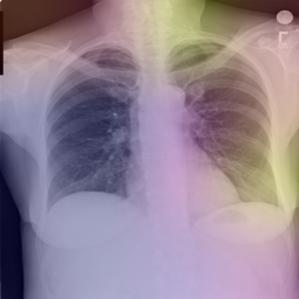

In [24]:
display_gradcam(img_path, heatmap, cmap="plasma")

# Explaining the decision with Grad-CAM

In [158]:
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)


In [159]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


In [160]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

200

In [161]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap( img_array, model, base_model_name="resnet50v2",target_layer_name="conv5_block3_out")
        img = get_gradcam_image(img_path, heatmap)

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

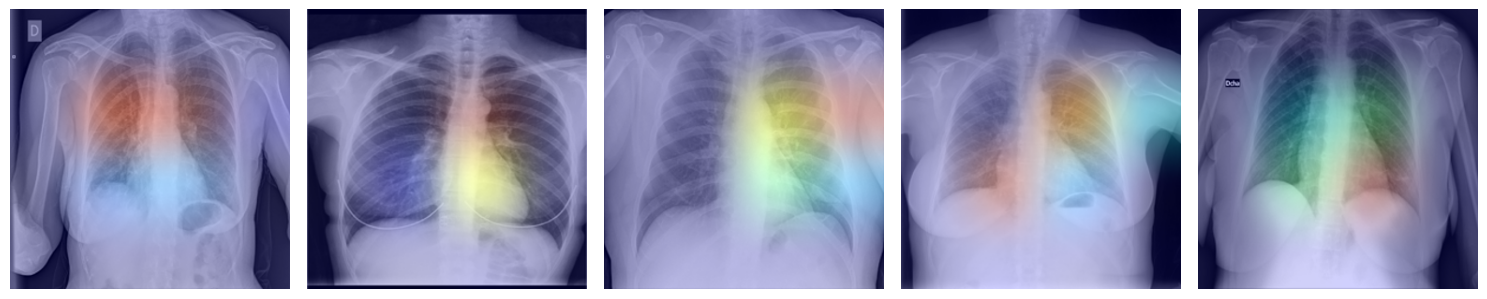

In [162]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(Covid_misclassified, img_size, model, start_index = 20, stop_index = 25 )

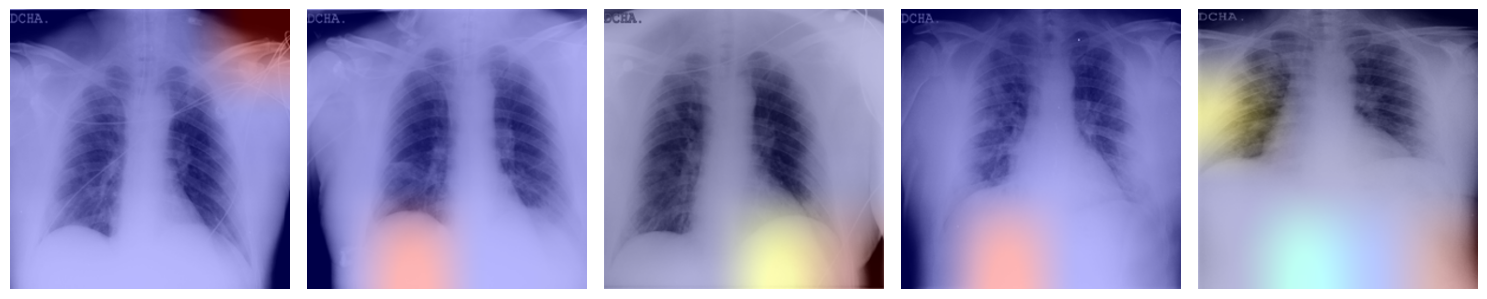

In [167]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(Covid_correctclassified, img_size, model, start_index = 0, stop_index = 5 )

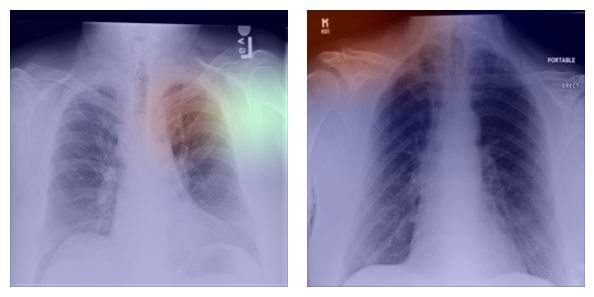

In [165]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(normal_misclassified, img_size, model, start_index = 0, stop_index = len(normal_misclassified) )


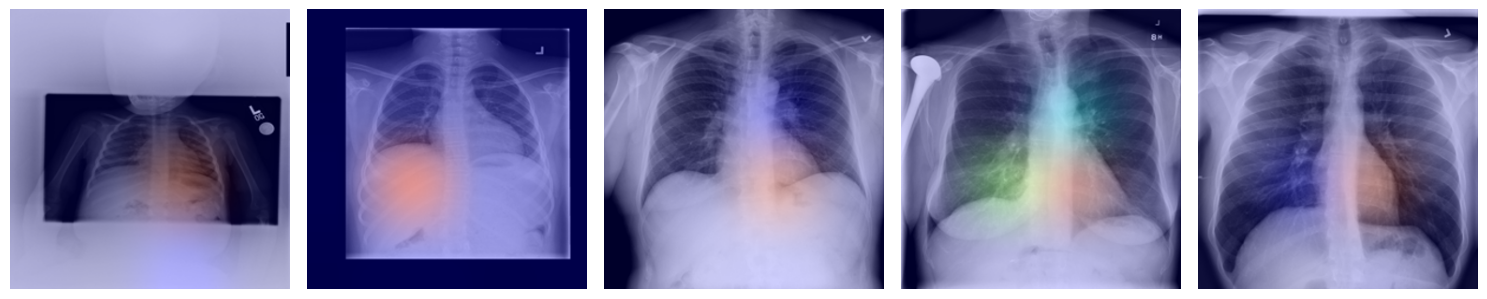

In [166]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(normal_correctclassified, img_size, model, start_index = 0, stop_index = 5 )